In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import time
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random
#import stanza

# from custom_preprocessing import CustomPreProcessing
# from custom_preprocessing import PreProcessing


import sklearn
from sklearn.utils import class_weight
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, recall_score, f1_score
from sklearn.metrics import make_scorer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras.utils import np_utils

from xgboost import XGBClassifier


import string
#import fasttext
#import fasttext.util
from tqdm import tqdm

# ---- Call tqdm to see progress bar with pandas
tqdm().pandas()
import re
import seaborn as sns
import matplotlib.pyplot as plt

0it [00:00, ?it/s]


In [6]:
#pretrained.save_model('/content/drive/MyDrive/Colab Notebooks/NLP1/Fasttext.h5')
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/TicketAssigningNLP/input_data (1).xlsx', index_col=0) 

In [7]:
df.reset_index(inplace = True)

In [8]:
df

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
...,...,...,...,...
8495,emails not coming in from zz mail,\r\n\r\nreceived from: avglmrts.vhqmtiua@gmail...,avglmrts vhqmtiua,GRP_29
8496,telephony_software issue,telephony_software issue,rbozivdq gmlhrtvp,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,vip2: windows password reset for tifpdchb pedx...,oybwdsgx oxyhwrfz,GRP_0
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62


In [9]:
df_processing = df.copy()
df_processing['text'] = df['Short description']+" "+df["Description"]
df_processing = df_processing[['text','Assignment group']]
df_processing

,text,Assignment group
0,login issue -verified user details.(employee# ...,GRP_0
1,outlook \r\n\r\nreceived from: hmjdrvpb.komuay...,GRP_0
2,cant log in to vpn \r\n\r\nreceived from: eylq...,GRP_0
3,unable to access hr_tool page unable to access...,GRP_0
4,skype error skype error,GRP_0
...,...,...
8495,emails not coming in from zz mail \r\n\r\nrece...,GRP_29
8496,telephony_software issue telephony_software issue,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,GRP_0
8498,machine nÃ£o estÃ¡ funcionando i am unable to ...,GRP_62


In [10]:
df_processing['Assignment group'].value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_73       1
GRP_61       1
GRP_35       1
GRP_64       1
GRP_67       1
Name: Assignment group, Length: 74, dtype: int64

In [11]:
#df_processing['Assignment group'].replace('GRP_',' ',inplace=True)
df_processing['Assignment group']= df_processing['Assignment group'].str.replace('GRP','')
df_processing['Assignment group']= df_processing['Assignment group'].str.replace('_','')
df_processing['Assignment group']= df_processing['Assignment group'].astype(int)

In [12]:
df_processing['text']= df_processing['text'].astype(str)

In [37]:
df_processing.isnull().sum()

text                0
Assignment group    0
dtype: int64

In [14]:
df_sampled = df_processing.sample(n=500, weights='Assignment group', random_state=1)

In [26]:
df_sampled

,text,Assignment group
3817,error message and different views during worki...,15
6307,i have created 2 new material numbers but when...,29
43,please reroute jobs on printer01 to printer02 ...,5
2871,engineering_tool urgent \n\nreceived from: uez...,25
1520,ms crm emails not coming to outlook ms crm em...,40
...,...,...
2963,please give me administration permission for m...,19
8387,ticket (ticket_no1538972) update to anftgup nf...,72
2077,crm buttons i have recently upgraded our calen...,22
3108,drucker dell 1350 cnw druckt alle seiten mit g...,33


In [30]:
def wl(text):
    return len(text.split(" "))
fig_df = pd.DataFrame()
fig_df['word_length']=df_processing['text'].apply(wl)
fig_df['char_length']=df_processing['text'].apply(len)
fig_df['text']= df_processing['text']

In [32]:
fig_df[["text","word_length"]].sort_values(by = "word_length",ascending = False).head(10)

,text,word_length
7345,security incidents - ( sw #in33501789 ) : broa...,1431
4087,security incidents - ( sw #in33895560 ) : mage...,1409
4089,security incidents - ( sw #in33895560 ) : mage...,1408
7995,security incidents - ( dsw #in33407676 ) : tra...,1364
7989,security incidents - ( dsw #in33407676 ) : tra...,1364
7997,security incidents - ( sw #in33544563 ) : poss...,1303
8002,security incidents - ( sw #in33544563 ) : poss...,1303
5072,erp-step interface programdnty not sending all...,1205
3965,security incidents - ( #in33809307 ) : possibl...,1176
7982,security incidents - ( dsw #in33390850 ) : sus...,1027


In [33]:
fig_df[["text","word_length"]].sort_values(by = "word_length",ascending = True).head(10)

,text,word_length
3383,nan,1
3910,nan,1
3915,nan,1
3921,nan,1
3924,nan,1
2604,nan,1
4395,nan,1
3906,nan,1
4341,nan,1
3010,ç”¨å‹-åº“å­˜å¸å’ŒçŽ°å­˜é‡ä¸ç¬¦ ç”¨å‹-åº“å...,2


In [ ]:
fig_df[["text","char_length"]].sort_values(by = "char_length",ascending = False).head()

In [35]:
fig_df[["text","char_length"]].sort_values(by = "char_length",ascending = True).head()

,text,char_length
3906,nan,3
2604,nan,3
3915,nan,3
4395,nan,3
3921,nan,3


In [44]:
fig_df.dtypes

word_length     int64
char_length     int64
text           object
dtype: object

In [47]:
df_nan = fig_df.loc[fig_df['word_length'] == 1]
#df.loc[df['column_name'] == some_value]

In [49]:
#df_processing[df_processing['text'].isna()]

df_nan

,word_length,char_length,text
2604,1,3,nan
3383,1,3,nan
3906,1,3,nan
3910,1,3,nan
3915,1,3,nan
3921,1,3,nan
3924,1,3,nan
4341,1,3,nan
4395,1,3,nan


In [ ]:
#drop null values

In [50]:
df_processing.drop(df_nan.index)

,text,Assignment group
0,login issue -verified user details.(employee# ...,0
1,outlook \r\n\r\nreceived from: hmjdrvpb.komuay...,0
2,cant log in to vpn \r\n\r\nreceived from: eylq...,0
3,unable to access hr_tool page unable to access...,0
4,skype error skype error,0
...,...,...
8495,emails not coming in from zz mail \r\n\r\nrece...,29
8496,telephony_software issue telephony_software issue,0
8497,vip2: windows password reset for tifpdchb pedx...,0
8498,machine nÃ£o estÃ¡ funcionando i am unable to ...,62


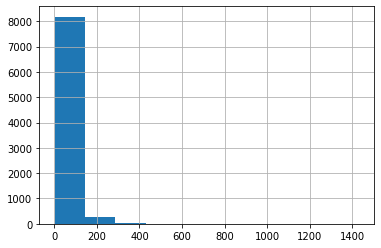

In [16]:
fig_df['word_length'].hist()

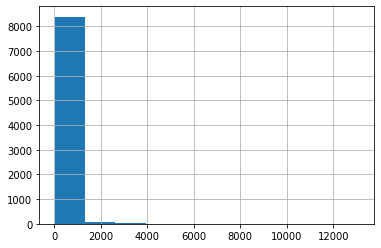

In [17]:
fig_df['char_length'].hist()

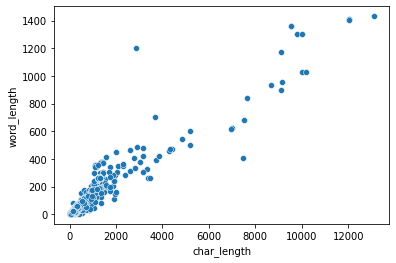

In [19]:
sns.scatterplot(x='char_length',y='word_length',data=fig_df)

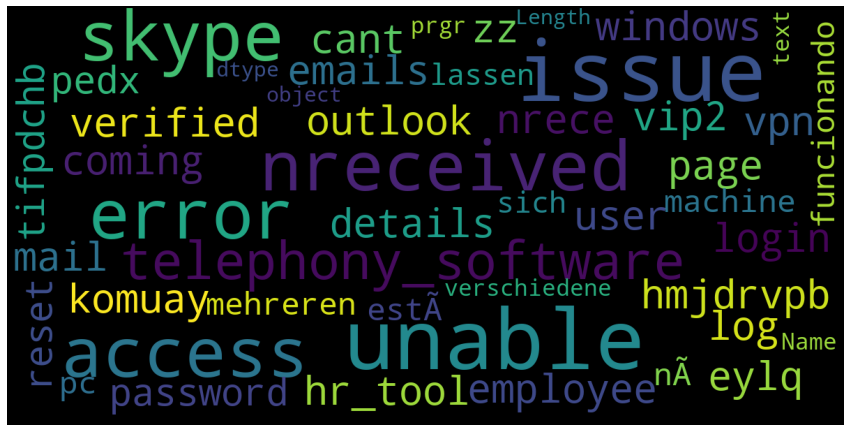

In [23]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

#show_wordcloud(df['reviews.text'])
show_wordcloud(df_processing['text'])

In [24]:
# Functions for preprocessing
def remove_upper_case( text):
        '''
        Function to transform upper string in title words
        @param text: (str) text 
        @return: (str) text without upper words 
        '''
        sentences = text.split("\n")
        new_sentences = []
        for i in sentences:
            words = text.split()
            stripped = [w.title() if w.isupper() else w for w in words]
            new_sentences.append(" ".join(stripped))
        return "\n".join(new_sentences)
def remove_URL( text):
        '''
        Function to remove url from text.
        @param text: (str) sentence
        @return: (str) clean text
        
        '''
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)
    
    
def remove_html( text):
        '''
        Function regex to clean text from html balises.
        @param text: (str) sentence 
        @return: (str) clean text 
        '''
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)
    
    

def remove_emoji( text):
        '''
        Function to remove emojis, symbols and pictograms etc from text
        @param text: (str) sentences 
        @return: (str) clean text 
        '''
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

def remove_special_char( text):
        '''
        Function to remove emojis, symbols and pictograms etc from text
        @param text: (str) sentences 
        @return: (str) clean text 
        '''
        spcl_char_pattern = re.compile(r'[^`~!@#$%^&*()_+={}\[\]|\\:;“’<,>.?๐฿]*$')
        return spcl_char_pattern.sub(r'',text)
        return spcl_char_pattern.sub(r'', text)

In [25]:
TEXT = 'text'

In [27]:
df_sampled[TEXT] = df_sampled[TEXT].apply(remove_upper_case)
df_sampled[TEXT] = df_sampled[TEXT].apply(remove_URL)
df_sampled[TEXT] = df_sampled[TEXT].apply(remove_html)
df_sampled[TEXT] = df_sampled[TEXT].apply(remove_emoji)
df_sampled[TEXT] = df_sampled[TEXT].apply(remove_special_char)



               Short description  ... Assignment group
0                    login issue  ...            GRP_0
1                        outlook  ...            GRP_0
2             cant log in to vpn  ...            GRP_0
3  unable to access hr_tool page  ...            GRP_0
4                   skype error   ...            GRP_0

[5 rows x 4 columns]


In [28]:

print(df_sampled.head())

                                                   text  Assignment group
3817                                                                   15
6307  i have created 2 new material numbers but when...                29
43    please reroute jobs on printer01 to printer02 ...                 5
2871  engineering_tool urgent received from: uezonyw...                25
1520                                                                   40
